# Предсказываем спрос на аренду велосипедов

https://www.kaggle.com/c/bike-sharing-demand

Системы совместного использования велосипедов - это средство аренды велосипедов, где процесс получения членства, аренды и возврата велосипедов автоматизирован через сеть киосков по всему городу. Используя эти системы, люди могут арендовать велосипед из одного места и возвращать его в другое место по мере необходимости. В настоящее время в мире действует более 500 программ обмена велосипедами.

Данные, сгенерированные этими системами, делают их привлекательными для исследователей, поскольку продолжительность поездки, место отправления, место прибытия и истекшее время явно записаны. Поэтому системы совместного использования велосипедов функционируют как сенсорная сеть, которую можно использовать для изучения мобильности в городе. В этом конкурсе участников просят объединить исторические модели использования с данными о погоде, чтобы прогнозировать спрос на аренду велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.

Тренировочный набор состоит из первых 19 дней каждого месяца, а тестовый набор - с 20-го по конец месяца.


# Задача 

Спрогнозировать общее количество велосипедов, арендованных в течение каждого часа, покрываемого тестовым набором, используя только информацию, доступную до периода проката.

# Описание датасета:

Параметры:

datetime - почасовая дата + отметка времени

season - 1 = весна, 2 = лето, 3 = осень, 4 = зима

holiday - считается ли день праздником

workingday - будь то выходной или праздничный день

weather - 1: Ясно, Облачно, Небольшая Облачность

2: Туман + Облачно, Туман + Разбитые облака, Туман + Немного облаков, Туман

3: легкий снег, легкий дождь + гроза + рассеянные облака, легкий дождь + рассеянные облака

4: сильный дождь + ледяные поддоны + гроза + туман, снег + туман

temp - температура в градусах Цельсия

atemp - "ощущается как" температура в градусах Цельсия

humidity - относительная влажность

windspeed - скорость ветра

casual - количество инициированных прокатов незарегистрированных пользователей

registered - количество зарегистрированных арендованных пользователей

count - количество всех арендных плат

# Туториал

#### 1) Скачаем необходимые для работы библиотеки

        a) numpy - расширение языка Python, добавляющее поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами
        б) pandas - различные структуры данных и анализ
        в) pydot
        г) sklearn - С помощью нее можно реализовать различные алгоритмы классификации, регрессии и кластеризации, в том числе алгоритмы SVM, случайного леса, k-ближайших соседей и DBSCAN, которые построены на взаимодействии библиотек NumPy и SciPy с Python.
        д) matplotlib - библиотека на языке программирования Python для визуализации данных двумерной (2D) графикой (3D графика также поддерживается)
        е) seaborn - это библиотека визуализации данных Python, основанная на matplotlib.

In [3]:
import numpy as np
import pandas as pd
import pydot as p
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.ensemble import RandomForestRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### 2) Скачаем необходимые данные и исследуем их начальное состояние

In [4]:
#импорт датасета
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
submission = pd.read_csv('sampleSubmission.csv')

In [6]:
#вывод первых пяти строк трейновой выборки
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
#вывод первых пяти строк тестовой выборки
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Выводим статистику для train по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
# Выводим статистику для test по значениям признаков: 
# среднее, стандартное отклонение, минимальное и максимальное значения, квартили
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [7]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [13]:
# узнаем по каждому параметру кол-во переменных, их формат и есть ли пустые значения.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [15]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
train.shape

(10886, 12)

In [17]:
# узнаем кол-во иследуемых объектов и кол-во оцениваемых признаков
test.shape

(6493, 9)

In [64]:
# Проверка на пропущенные данные
train.isnull().any().any()

False

In [65]:
# Проверка на пропущенные данные
test.isnull().any().any()

False

#### Выводы: 
          1) Нет пропущенных значений по всем признакам
          2) В train есть 3 target переменных (casual, registered, count) 
          3) После обучения моделей на train.csv сделаем прогноз для тестовой выборки test.csv

#### 3) Чтобы лучше разобраться в данных, визуализируем их с помощью библиотеки matplotlib, отдельно выделим таргет переменную count

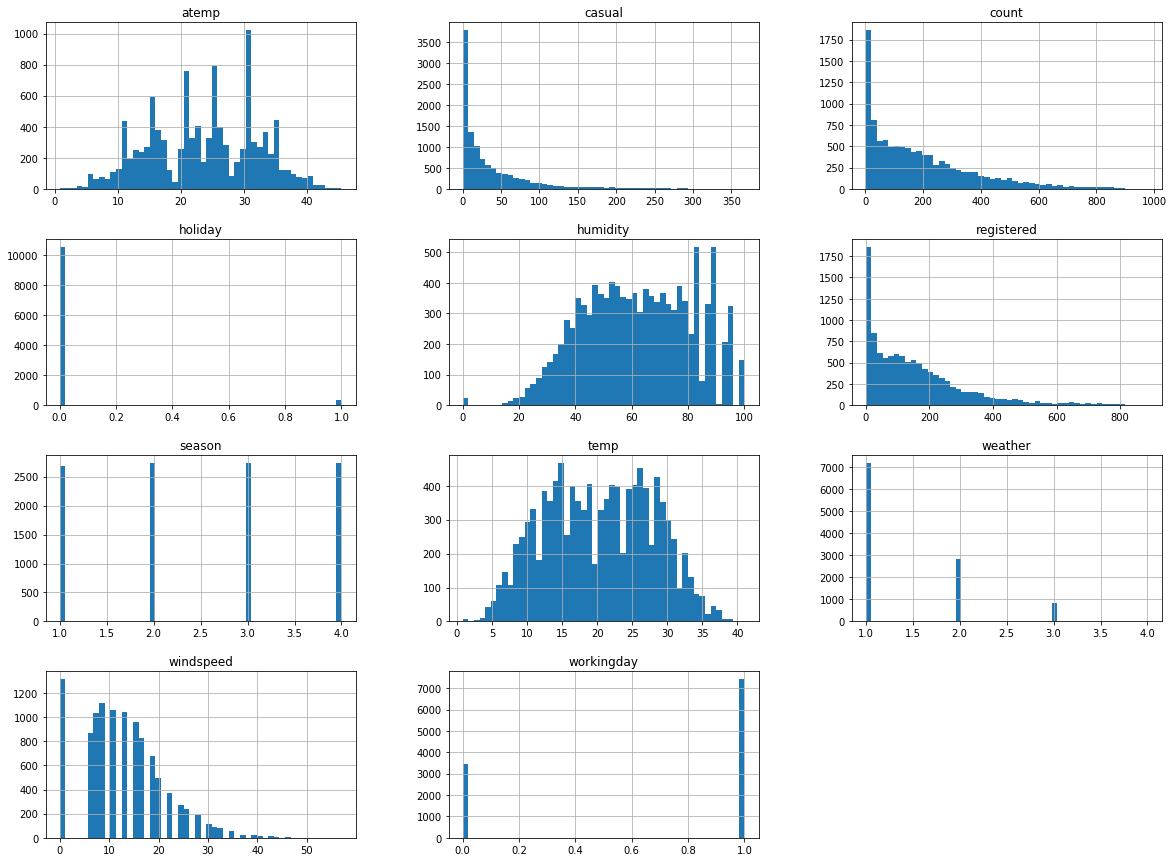

In [9]:
# визуализация данных
train.hist(bins=50, figsize=(20,15))
plt.show()

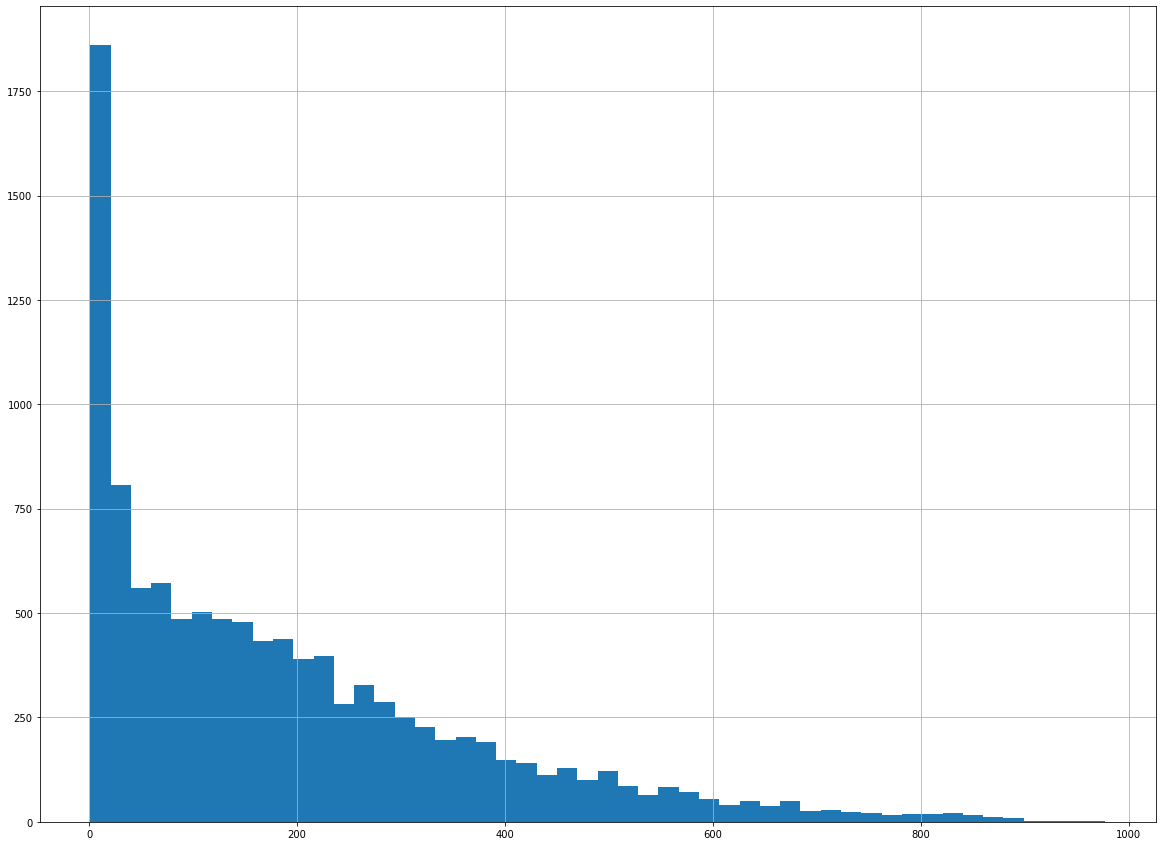

In [26]:
train['count'].hist(bins=50, figsize=(20,15))

#### 4) Рассмотрим корреляцию между нашими параметрами

В математической статистике корреляция — понятие, которым отмечают связь между явлениями, если одно из них входит в число причин, определяющих другие, или если имеются общие причины, воздействующие на эти явления (функция является частным случаем корреляции); корреляция может быть более или менее тесной (т. е. зависимость одной величины от другой — более или менее ясно выраженной); число, показывающее степень тесноты корреляции, называется коэффициентом корреляции (это число заключено между -1 и 1);

1 - положительная корреляция -1 - отрицательная корреляция 0 - не коррелируют

В pandas есть 3 метода для функции corr



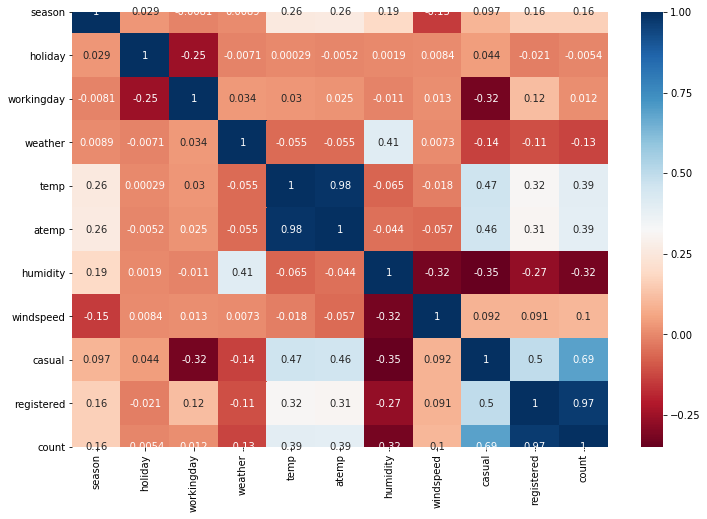

In [28]:
#pearson : standard correlation coefficient - стандартный коэффициент корреляции 
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="pearson"), annot =True, cmap='RdBu')
plt.show()

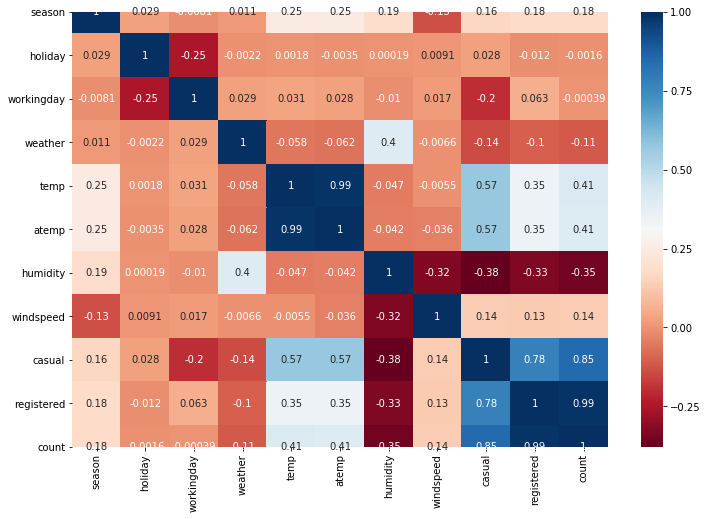

In [30]:
# spearman : Spearman rank correlation - Коэффициент ранговой корреляции Спирмена
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="spearman"), annot =True, cmap='RdBu')
plt.show()

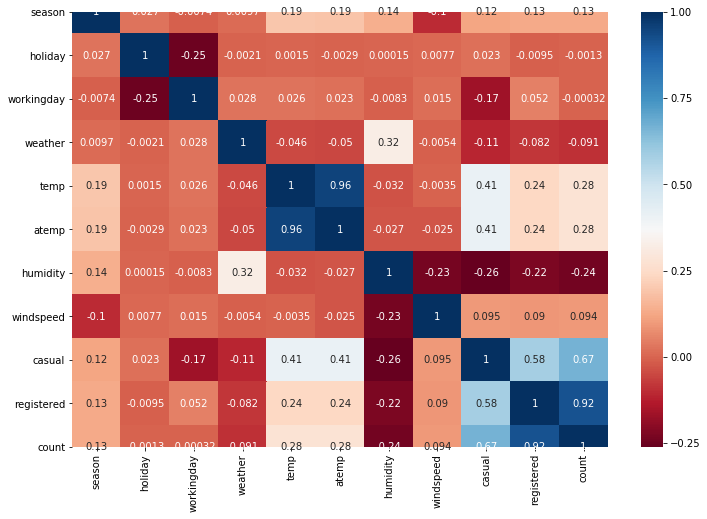

In [31]:
# kendall : Kendall Tau correlation coefficient - Коэффициент ранговой корреляции Кендалла
ax, fig = plt.subplots(figsize=(12,8))
sns.heatmap(train.corr(method="kendall"), annot =True, cmap='RdBu')
plt.show()

In [40]:
# делим datetime на параметры
train.datetime = train.datetime.apply(pd.to_datetime)
train['month'] = train.datetime.apply(lambda x : x.month)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train['date'] = train.datetime.apply(lambda x : x.day)
train['weekday'] = train.datetime.apply(lambda x : x.weekday())
train.head(400)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,date,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,0,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,2,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,3,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2011-01-17 23:00:00,1,1,0,3,6.56,6.820,86,19.0012,1,3,4,1,23,17,0
396,2011-01-18 12:00:00,1,0,1,2,8.20,9.090,86,22.0028,0,3,3,1,12,18,1
397,2011-01-18 13:00:00,1,0,1,2,8.20,9.850,86,15.0013,0,22,22,1,13,18,1
398,2011-01-18 14:00:00,1,0,1,2,9.02,11.365,80,11.0014,2,26,28,1,14,18,1


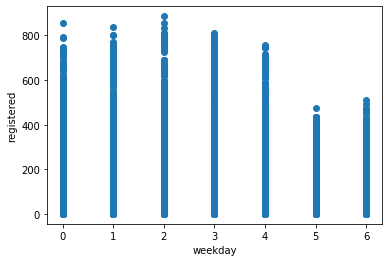

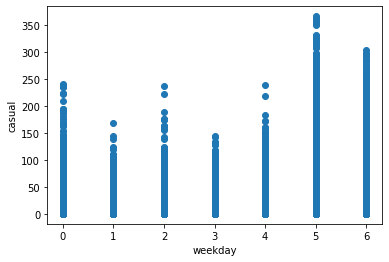

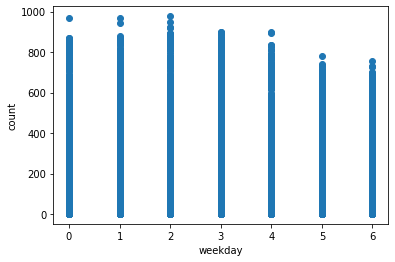

In [43]:
# статистика по дням недели для зарегестрированных пользователей
plt.scatter(train['weekday'], train['registered'])
plt.xlabel('weekday')
plt.ylabel('registered')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['casual'])
plt.xlabel('weekday')
plt.ylabel('casual')
plt.show()
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['count'])
plt.xlabel('weekday')
plt.ylabel('count')
plt.show()

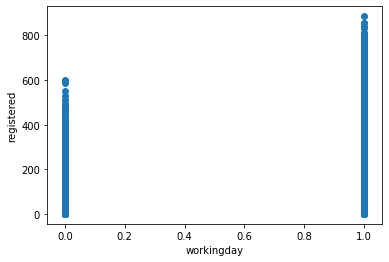

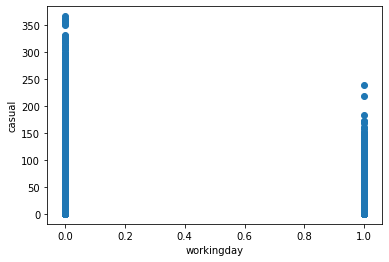

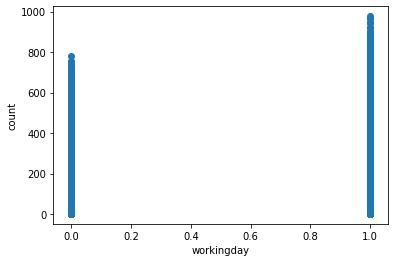

In [44]:
# статистика по рабочим/выходным дням недели для зарегестрированных пользователей
plt.scatter(train['workingday'], train['registered'])
plt.xlabel('workingday')
plt.ylabel('registered')
plt.show()
# статистика по рабочим/выходным дням недели для не зарегестрированных пользователей
plt.scatter(train['workingday'], train['casual'])
plt.xlabel('workingday')
plt.ylabel('casual')
plt.show()
# статистика по рабочим/выходным дням недели для всех пользователей
plt.scatter(train['workingday'], train['count'])
plt.xlabel('workingday')
plt.ylabel('count')
plt.show()

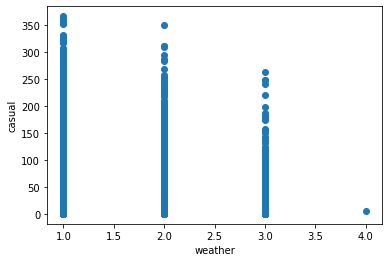

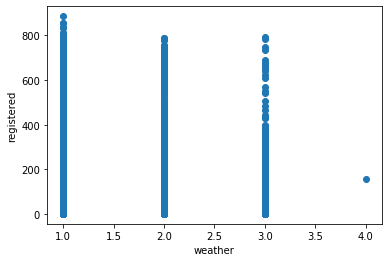

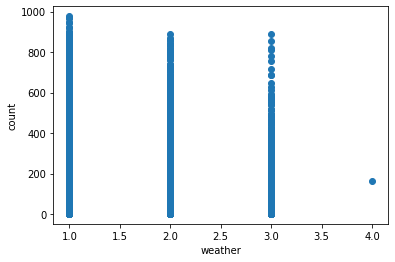

In [45]:
# статистика по погоде для незарегистрированных пользователей
plt.scatter(train['weather'], train['casual'])
plt.xlabel('weather')
plt.ylabel('casual')
plt.show()

# статистика по погоде для зарегистрированных пользователей
plt.scatter(train['weather'], train['registered'])
plt.xlabel('weather')
plt.ylabel('registered')
plt.show()

# статистика по погоде для всех пользователей
plt.scatter(train['weather'], train['count'])
plt.xlabel('weather')
plt.ylabel('count')
plt.show()

Отметим что данные являются ли пользователи зарегистрированными или нет не влияют на таргет переменную, поэтому удалим столбцы registered и casual, также признаки workingday и weekday имеют схожий смысл, поэтому можем удалить один из них.

In [47]:
X = train.drop(['datetime','weekday','count', 'casual', 'registered'], axis = 1)
Y = train['count'].values

In [51]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, random_state=42)

In [52]:
dtree = DecisionTreeClassifier(random_state = 17)
dtree.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [53]:
dtree.score(train_data, train_labels)

1.0

In [63]:
print(test_labels[:10])
(dtree.predict(np.array(test_data)))[:10]

[127  13 163 233 222 166 144 376 601  53]


array([183,   5, 109, 367,  86, 181, 132, 345, 368, 138], dtype=int64)

In [72]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date'], axis = 1)
result = result.drop(['datetime'], axis = 1)
predictions = dtree.predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmissionTree.csv', index=False)
output.head()

,datetime,count
0,2011-01-20 00:00:00,15
1,2011-01-20 01:00:00,8
2,2011-01-20 02:00:00,2
3,2011-01-20 03:00:00,2
4,2011-01-20 04:00:00,2


In [ ]:
from  sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeClassifier(random_state=17),
                  param_grid = {'max_depth' : range(5, 15),
                                'min_samples_leaf' : range(1, 10),
                                'min_samples_split' : range(2, 10),
                                'criterion' : ['gini', 'entropy'],
                               'presort' : ['auto',True,False]},
                  cv=5, scoring='accuracy').fit(train_data, train_labels)

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [91]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [83]:
dtree2 = DecisionTreeClassifier(max_depth = 8,min_samples_leaf = 1, min_samples_split = 2, criterion = 'gini', presort = 'auto')
dtree2.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='auto',
                       random_state=None, splitter='best')

In [84]:
dtree2.score(train_data, train_labels)

0.09211170994610485

In [85]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date'], axis = 1)
result = result.drop(['datetime'], axis = 1)
predictions = dtree2.predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmissionTree2.csv', index=False)
output.head()

,datetime,count
0,2011-01-20 00:00:00,15
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,1
3,2011-01-20 03:00:00,1
4,2011-01-20 04:00:00,1


In [26]:
binary_columns = ['holiday', 'workingday']
binary_indices = np.array([(column in binary_columns) for column in X.columns], dtype = bool)

categorical_columns = ['season', 'weather', 'month', 'date', 'weekday']
categorical_indieces = np.array([(column in  categorical_columns) for column in X.columns], dtype = bool)

numeric_columns = ['temp', 'atepm', 'humidity', 'windspeed', 'hour']
numeric_indices = np.array([(column in numeric_columns) for column in X.columns], dtype = bool)

regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 200)
estimator = pipeline.Pipeline(steps = [
    ('feature_processing0', pipeline.FeatureUnion(transformer_list = [
        ('binary_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_indices], validate = True)),
        
        ('numeric_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean = 0.))
                ])),
        
        ('categorical_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indieces])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
                ])),
    ])),
    ('model_fitting', regressor)
    ]
)

In [27]:
estimator.fit(np.array(train_data), train_labels)

Pipeline(memory=None,
         steps=[('feature_processing0',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001DA5E20CC18>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=True)),
                                                ('numeric_processing',
                        

In [62]:
estimator.score(train_data, train_labels)

0.9795494943916406

In [28]:
metrics.mean_absolute_error(test_labels, estimator.predict(np.array(test_data)))

42.85296581891898

Text(0.5, 1.0, 'Results')

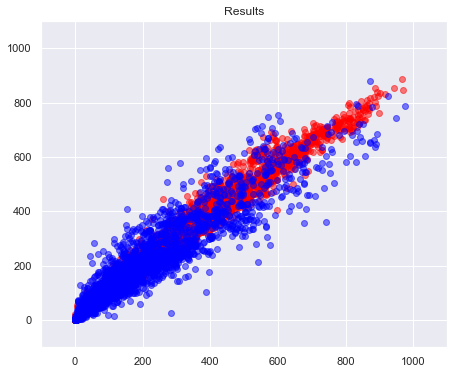

In [29]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, estimator.predict(np.array(train_data)), alpha = 0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(np.array(test_data)), alpha = 0.5, color = 'blue')
pylab.title("Results")

In [30]:
print(test_labels[:10])
(estimator.predict(np.array(test_data)))[:10]

[127  13 163 233 222 166 144 376 601  53]


array([180.36015649,  49.86      , 162.256     , 166.76361813,
       182.25      , 159.7946526 , 165.44149298, 390.28452367,
       629.88892023,  80.70729398])

In [31]:
result = pd.read_csv('test.csv', header = 0, sep = ',')
result.datetime = result.datetime.apply(pd.to_datetime)
result['month'] = result.datetime.apply(lambda x : x.month)
result['hour'] = result.datetime.apply(lambda x : x.hour)
result['date'] = result.datetime.apply(lambda x : x.day)
result['weekday'] = result.datetime.apply(lambda x : x.weekday())
output = result
output = output.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'date', 'weekday'], axis = 1)
result = result.drop(['datetime'], axis = 1)


predictions = estimator.predict(np.array(result))
output = pd.read_csv('sampleSubmission.csv', header = 0, sep = ',')
output['count'] = predictions
output.to_csv('sampleSubmissionRandomForest.csv', index=False)
output.head()

,datetime,count
0,2011-01-20 00:00:00,15.237733
1,2011-01-20 01:00:00,4.015000
2,2011-01-20 02:00:00,3.096720
3,2011-01-20 03:00:00,3.435745
4,2011-01-20 04:00:00,2.878129
